# **Neural Architecture Learning for Semantic Segmentation**

# **Objective:** 
Train a NAL network and compare with a Unet-like

# **Dataset**
Semcity Toulouse dataset

**Sensor:** Worldview

**Bands:** 8 (each image)

**Spatial Resolution:** 0.5m

**Steps**

Alternatively:
  - Train the weights of a full network
  - Train the architecture using sigmoid gates

Prune the network:
  - Train the number of filters

Heavily inspired by GUO (2021), with the search space from KIM (2019)

GUO, Q. et al. Differentiable Neural Architecture Learning for Efficient Neural Network Design. arXiv:2103.02126 [cs], 2 mar. 2021. 

KIM, S. et al. Scalable Neural Architecture Search for 3D Medical Image Segmentation. arXiv:1906.05956 [cs, eess, stat], 13 jun. 2019. 




In [ ]:
import tensorflow
if tensorflow.__version__!="2.2.0":
  !pip install tensorflow-gpu==2.2.0 tensorflow==2.2.0
  #!kill -9 -1

**Restart the runtime, please.**

In [ ]:
print(tensorflow.__version__)

2.2.0


In [ ]:
classes=[
"void",
"impervious surface",
"building",
"pervious surface",
"high vegetation",
"car",
"water",
"sport venues"
]

In [ ]:
from google.colab import drive
# mount your Google Drive
#drive.mount('/content/drive')
#root_path = '/content/drive/MyDrive/Colab Notebooks/' 
import os
root_path=os.getcwd()

# **Import libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from numpy import random
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
import gdal, os, shutil,sklearn
from osgeo import gdal_array
import sklearn.model_selection
import seaborn as sns; sns.set()
import time

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
# Parameters
batch_size = 8
learning_rate = 1e-3
epochs = 100
patch_size = 256
#stride = 256-32 #using 32 pixels of overlap
stride = 256 #using 0 pixels of overlap
#stride = 256-64 #using 128 pixels of overlap
name = 'model'

# Dataset

In [ ]:
#retrieving the TIFs
if not os.path.exists('nas_deeplearning.tar.gz'):
  !gdown --id 1keP31cD2guFETfg0mT0sUDR5jCKWmD1r
!tar -xvzf nas_deeplearning.tar.gz --skip-old-files
datasetdir=os.path.join(os.getcwd(),'nas_deeplearning')

TLS_BDSD_M/
tar: TLS_BDSD_M: skipping existing file
TLS_BDSD_M/TLS_BDSD_M_07.tif
tar: TLS_BDSD_M/TLS_BDSD_M_07.tif: skipping existing file
TLS_BDSD_M/TLS_BDSD_M_08.tif
tar: TLS_BDSD_M/TLS_BDSD_M_08.tif: skipping existing file
TLS_BDSD_M/TLS_BDSD_M_03.tif
tar: TLS_BDSD_M/TLS_BDSD_M_03.tif: skipping existing file
TLS_BDSD_M/TLS_BDSD_M_04.tif
tar: TLS_BDSD_M/TLS_BDSD_M_04.tif: skipping existing file
TLS_indMap/
tar: TLS_indMap: skipping existing file
TLS_indMap/TLS_indMap_07.tif
tar: TLS_indMap/TLS_indMap_07.tif: skipping existing file
TLS_indMap/TLS_indMap_03.tif
tar: TLS_indMap/TLS_indMap_03.tif: skipping existing file
TLS_indMap/TLS_indMap_08.tif
tar: TLS_indMap/TLS_indMap_08.tif: skipping existing file
TLS_indMap/TLS_indMap_04.tif
tar: TLS_indMap/TLS_indMap_04.tif: skipping existing file


# Patch extracting

In [ ]:
#Dataset extraction helper functions
def extract_patches(image, patch_size, stride): #returns both the list of patches and an ordered set of patches.
  #image=np.pad(image,((0,0),(border_size,border_size),(border_size,border_size)),mode='reflect')
  image = tf.expand_dims(image,0) # To create the batch information
  border_size=int((patch_size-stride)/2)
  patches = tf.image.extract_patches(image,[1,patch_size,patch_size,1],[1,stride,stride,1], rates=[1, 1, 1, 1],padding="VALID")
  return np.array(tf.reshape(patches, shape=[-1, patch_size, patch_size, image.shape[3]]) )

def rebuildImage(patches,image,patch_size,stride):
  border_size=int((patch_size-stride)/2)
  cropped=tf.image.crop_to_bounding_box(patches_train,border_size,border_size,stride,stride)
  cols=int(np.ceil(image.shape[0]/stride))
  cropped_rows=np.array_split(cropped,cols)
  newRows=[]
  for row in cropped_rows:
    newRows.append(np.concatenate(row, 1))
  return np.concatenate(newRows,0)

In [ ]:
band_images_pattern="TLS_BDSD_M/TLS_BDSD_M_{:02d}.tif"
label_images_pattern="TLS_indMap/TLS_indMap_{:02d}.tif"

imageIds=[3,4,7]
label_patches=None
band_patches=None
for imageId in imageIds:
  band_image=band_images_pattern.format(imageId)
  label_image=label_images_pattern.format(imageId)
  bandArray = gdal_array.LoadFile(band_image)
  bandArray = np.moveaxis(bandArray, 0, -1)#/bandArray.max()
  patches=extract_patches(bandArray,patch_size,stride)
  if band_patches is None: 
    band_patches=patches
  else:
    print(band_patches.shape)
    band_patches=np.concatenate((band_patches,patches))
  labelsArray = gdal_array.LoadFile(label_image) #this is a grayscale image
  labelsArray = labelsArray.reshape(labelsArray.shape+(1,))
  labelsArray = tf.keras.utils.to_categorical(labelsArray)
  patches=extract_patches(labelsArray,patch_size,stride)
  if label_patches is None: 
    label_patches=patches
  else:
    label_patches=np.concatenate((label_patches,patches))
scale=band_patches.max()



(169, 256, 256, 8)
(338, 256, 256, 8)


In [ ]:
print(band_patches.shape)
print(label_patches.shape)


(507, 256, 256, 8)
(507, 256, 256, 8)


In [ ]:
split = sklearn.model_selection.train_test_split(band_patches, label_patches, test_size=0.20, random_state=42)
(trainX, valX, trainY, valY) = split
number_class=label_patches.shape[-1]
print(trainX.shape)
print(valX.shape)

(405, 256, 256, 8)
(102, 256, 256, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test sample No.  25


(-0.5, 255.5, 255.5, -0.5)

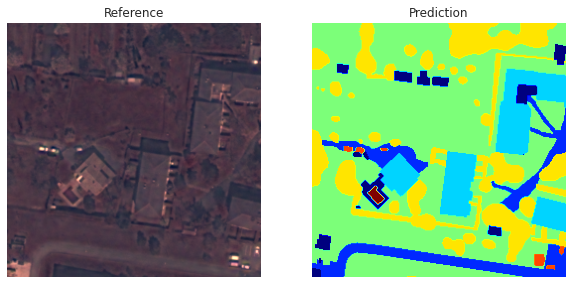

In [ ]:
fig = plt.figure(figsize = (10,10))
#n_sample = 14
n_sample = 25
print('Test sample No. ', n_sample)
plt.subplot(1,2,1)
plt.imshow((np.flip(trainX[n_sample][:,:,:3],2))/scale*4)
plt.title('Reference')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.argmax(trainY[n_sample], axis=-1), cmap = 'jet')
plt.title('Prediction')
plt.axis('off')

In [ ]:
trainX[n_sample][:,:,:3].shape

(256, 256, 3)

# NAL custom classes


In [ ]:
class SigmoidGate(tf.keras.layers.Layer):
  def __init__(self, delta_scale=1,**kwargs):
    super(SigmoidGate, self).__init__(**kwargs)
    self.delta_scale=delta_scale
  def build(self, input_shape):
    self.s = self.add_weight(shape=[1], initializer = 'zeros', trainable=True)
  def call(self,inputs):
    #return tf.math.sigmoid(self.s*self.delta_scale)
    return tf.math.multiply(tf.math.sigmoid(self.s*self.delta_scale),inputs) #this was used on single channel
  def get_config(self):
    return {"delta_scale": self.delta_scale}    

class zeroGate(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super(zeroGate, self).__init__(**kwargs)
  def call(self,inputs):
    return tf.math.multiply(0.,inputs) #this was used on single channel
   
#This is a helper function to define the convolutions, BN and RELU in the desired order. Every conv layer is built with this helper.
def sigmoid_operations(inputs, filters,size,conv_name='conv',dilation_rate=1,gated=True,notSeparable=False):
  basename=f"{conv_name}_{filters}_{size}"
  if notSeparable:
    x = Conv2D(filters=filters, kernel_size=(size, size), padding='same', name=basename,dilation_rate=dilation_rate)(inputs) #I'm going to add this because results are terrible and Kim, 2019 added too.
  else:
    x = SeparableConv2D(filters=filters, kernel_size=(size, size), padding='same', name=basename,dilation_rate=dilation_rate)(inputs)
  x = BatchNormalization(name=basename+"_bn")(x)
  x = ReLU(name=basename+"_relu")(x)
  if gated:
    x = SigmoidGate(name="ss_"+basename)(x) #change this for the bellow to use darts instead. The loss function should be changed.
  return x  

#This method creates the parallel convolution options for one cell. On this work the cells can differ from each other.
def cell(inputs, cell_name='cell',n_filters=64,architecture_vector=[]): #operations follow Li et al (2019) - DARTS. I removed the pooling, zeros and skip to simpify the search
  layerList=[] #this will store the layers on this cell. If the architecture vector was given, this will not contain every possible layer.
  s=architecture_vector
  includeGate= not (len(s)>0) #So if we received the architecture, no gate will be included.
  #We're going to use the architecture vector if it exists. Some layers might not be added if we ran architecture training before rebuilding the network.
  
  #if not (s) or int(s.pop(0))==1:# skip connection. This only works with concatenate
  #  layerList.append(SigmoidGate(name="ss_"+cell_name+"_skip")(inputs))

  if not (s) or int(s.pop(0))==1: 
    layerList.append(sigmoid_operations(inputs, n_filters, 1, f"{cell_name}_c_1", notSeparable=True, gated=includeGate))
  if not (s) or int(s.pop(0))==1: 
    layerList.append(sigmoid_operations(inputs, n_filters, 3, f"{cell_name}_c_3", notSeparable=True, gated=includeGate))
  if not (s) or int(s.pop(0))==1: 
    layerList.append(sigmoid_operations(inputs, n_filters, 3, f"{cell_name}_a_5", notSeparable=True, dilation_rate=2, gated=includeGate))
  if not (s) or int(s.pop(0))==1:
    layerList.append(sigmoid_operations(inputs, n_filters, 3, f"{cell_name}_a_7", notSeparable=True, dilation_rate=3, gated=includeGate))
  #if not (s) or int(s.pop(0))==1:
  #  layerList.append(sigmoid_operations(inputs, n_filters, 3, f"{cell_name}_a_9", notSeparable=True, dilation_rate=4, gated=includeGate))
  if len(layerList)==1: #if we have an architecture_vector, the layerList for this cell might be single or empty!
    return layerList[0] #no merge needed
  elif len(layerList)>1:
    x=tf.keras.layers.Add()(layerList)
    #x=tf.keras.layers.Concatenate()(layerList) #weird, the results didn't change with concatenate, but parameters increased a LOT
    return x
  else:
    #this cell was skipped. Tested both zero and returning the same inputs. Same inputs was better.
    #return zeroGate(name=f"{cell_name}_ZERO")(inputs)
    return inputs 

def conv(inputs, filters,size,conv_name='conv'):
  basename=f"{conv_name}_{filters}_{size}"
  x = Conv2D(filters=filters, kernel_size=(size, size), padding='same', name=basename)(inputs)
  x = BatchNormalization(name=basename+"_bn")(x)
  x = ReLU(name=basename+"_relu")(x)
  return x  

adam = Adam(learning_rate = learning_rate , beta_1=0.9)

# Custom Loss (sum of sigmoids)

In [ ]:
#NAL Loss

Lambda_a=5*10e-5 #sigmoid loss learning rate. Guo et al (2021)

def NAL_loss(model):
  def custom_loss(y_true, y_pred): #We should change this later
    catloss = tf.keras.losses.categorical_crossentropy(y_true,y_pred)

    #Now we penalize the sum of s to force the network to learn fewer layers
    sigloss=0
    for layer in model.layers:
      if layer.name.startswith("ss_"):
        sigloss+=tf.math.sigmoid(layer.weights[0]*layer.delta_scale)
    return catloss+Lambda_a*sigloss
  return custom_loss

 # Model definition

In [ ]:
# Define our network
def NAL_unet(input_shape, n_classes, architecture_vector=[]):
  input_img = Input(input_shape)
  n_filters = [32, 64, 128, 128]
  s=architecture_vector[:] #copying the vector because we will change it while using the values on the cells
  print(architecture_vector) #This is the vector that tells us if any layer was pruned after training the architecture. If it's empty, we're training the architecture and every layer is going to be used.

  ## ENCODER
  x = conv(input_img,n_filters[0],3,'conv1_x')
  conv1= conv(x,n_filters[0],3,'conv1')
  x = MaxPool2D((2 , 2))(conv1)
  
  #x = conv(x,n_filters[1],3,'conv2')
  x= conv(x,n_filters[1],3,'conv2_x')
  conv2 = cell(x, "conv2",n_filters=n_filters[1],architecture_vector=s)
  x = MaxPool2D((2 , 2))(conv2)

  
  #conv3= conv(x,n_filters[2],3,'conv3')
  x = conv(x,n_filters[2],3,'conv3_x')
  conv3 = cell(x, "conv3",n_filters=n_filters[2],architecture_vector=s)
  x = MaxPool2D((2 , 2))(conv3)

  ## MIDDLE
  x = conv(x,n_filters[3],3,'conv4_x')
  #x= conv(x,n_filters[2],3,'conv4')
  conv4 = cell(x, "conv4",n_filters=n_filters[3],architecture_vector=s)

  ## DECODER
  x = UpSampling2D(size = (2,2), name="upsample1")(conv4)
  x = Concatenate(name ='skip3')([x,conv3])
  x = conv(x,n_filters[2],3,'dconv3_x')
  #x = cell(x, "dconv3",n_filters=n_filters[2],architecture_vector=s)
  x= conv(x,n_filters[2],3,'dconv3')

  x = UpSampling2D(size = (2,2), name="upsample2")(x)
  x = Concatenate(name ='skip2')([x,conv2])
  x = conv(x,n_filters[1],3,'dconv2_x')
  #x = cell(x, "dconv2",n_filters=n_filters[1],architecture_vector=s)
  x = conv(x,n_filters[1],3,'dconv2')
  
  x = UpSampling2D(size = (2,2), name="upsample3")(x)
  x = Concatenate(name ='skip1')([x,conv1])
  x = conv(x,n_filters[0],3,'dconv1')
  x = conv(x,n_filters[0],3,'dconv1_x')
  
  output = Conv2D(n_classes,(1,1), activation = 'softmax')(x)

  return Model(input_img , output) 

In [ ]:
print(band_patches[1].shape)
label_patches.shape[-1]

(256, 256, 8)


8

In [ ]:
net = NAL_unet(band_patches[1].shape, number_class)
net.summary()

[]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 8) 0                                            
__________________________________________________________________________________________________
conv1_x_32_3 (Conv2D)           (None, 256, 256, 32) 2336        input_2[0][0]                    
__________________________________________________________________________________________________
conv1_x_32_3_bn (BatchNormaliza (None, 256, 256, 32) 128         conv1_x_32_3[0][0]               
__________________________________________________________________________________________________
conv1_x_32_3_relu (ReLU)        (None, 256, 256, 32) 0           conv1_x_32_3_bn[0][0]            
_________________________________________________________________________________________

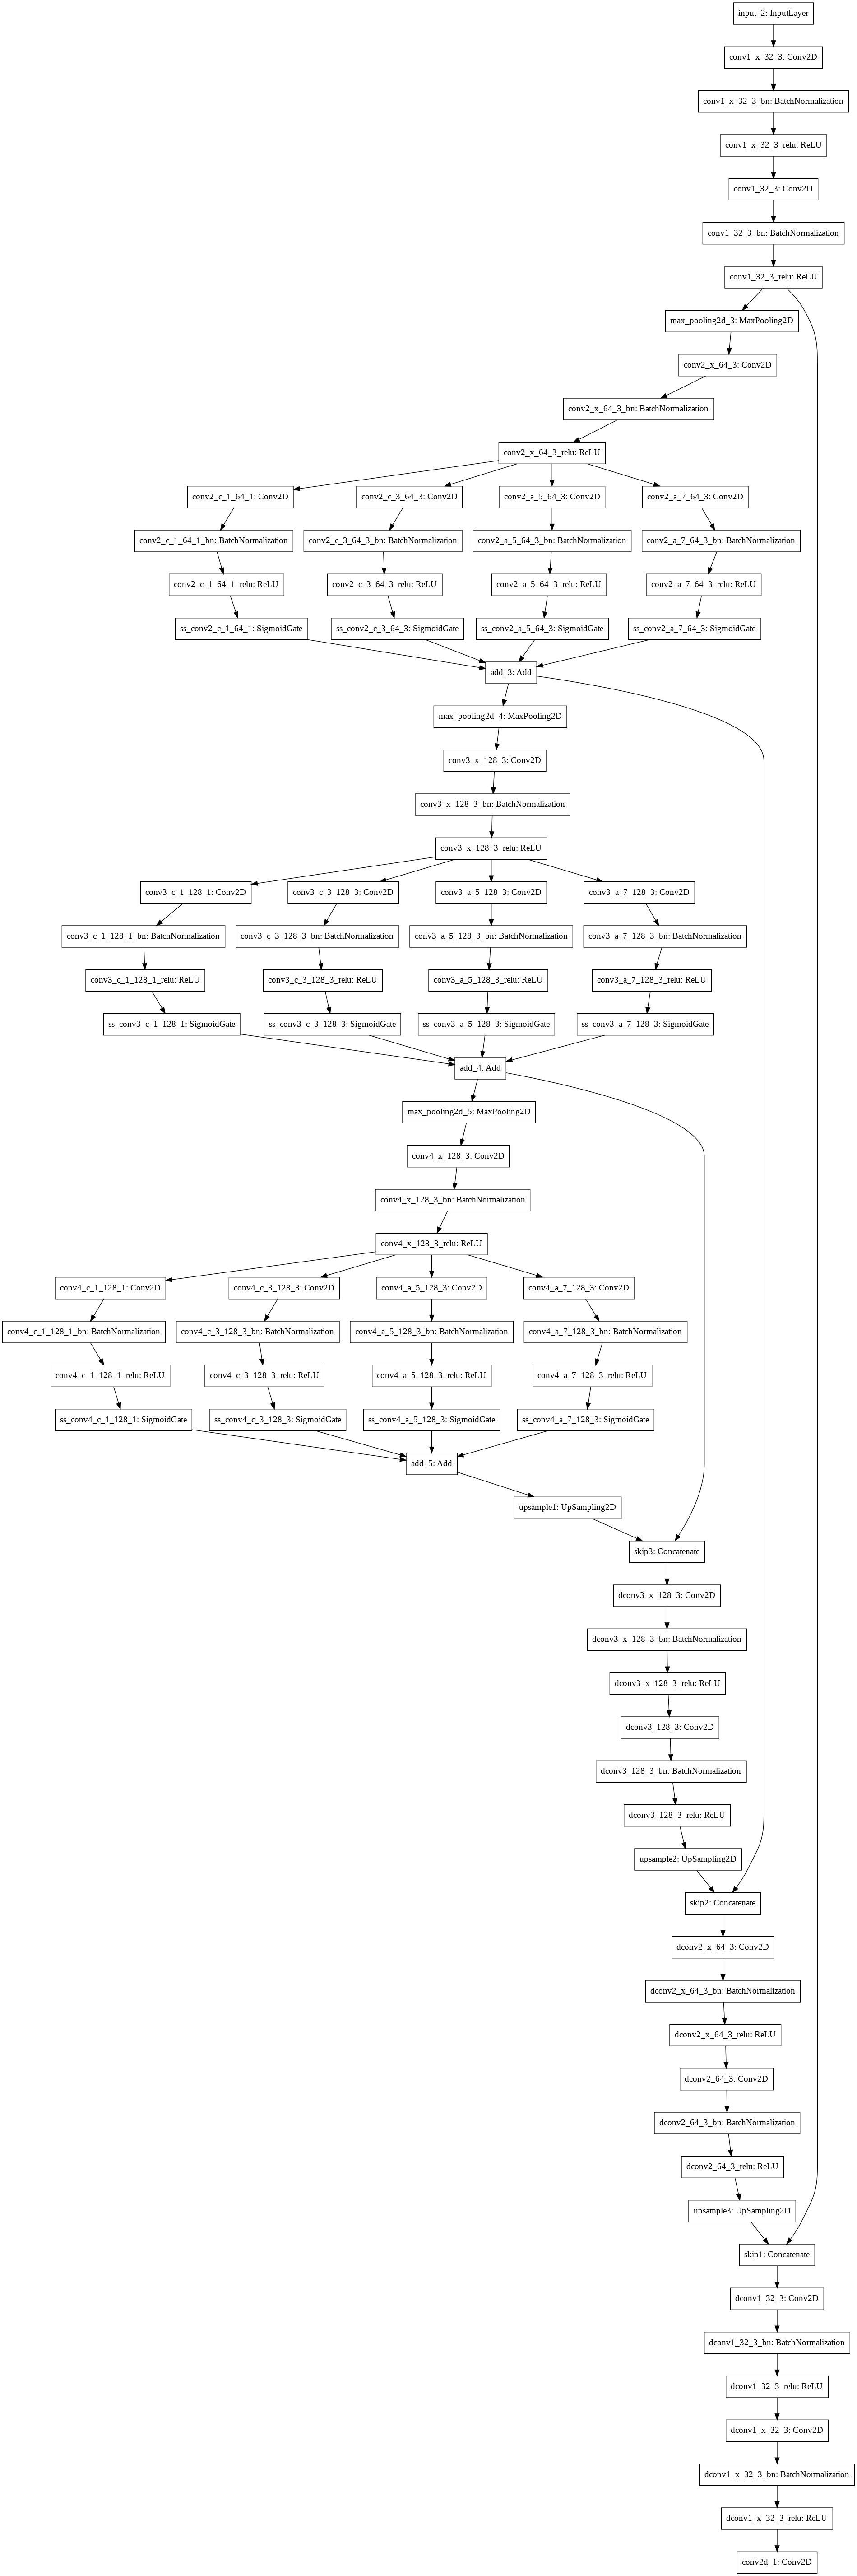

In [ ]:
#plot_model(net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(net, to_file='model_plot.png')

# Architecture Learning

In [ ]:
#History plot
def plotHistory(history):
  acc = history['accuracy']
  val_acc = history['val_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,3.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

Start training.. 
13/13 [==============================] - 7s 505ms/step - loss: 1.0416 - accuracy: 0.6716 - val_loss: 12.6359 - val_accuracy: 0.2162
Architecture vector:  [0.4969 0.5024 0.5079 0.5027 0.5011 0.4959 0.5017 0.5027 0.4868 0.485
 0.4926 0.4955]
13/13 [==============================] - 7s 504ms/step - loss: 0.8051 - accuracy: 0.7196 - val_loss: 9.8260 - val_accuracy: 0.2485
Architecture vector:  [0.5069 0.4999 0.5032 0.508  0.5182 0.4707 0.4741 0.4873 0.4506 0.4218
 0.4686 0.5155]
13/13 [==============================] - 7s 504ms/step - loss: 0.7333 - accuracy: 0.7375 - val_loss: 2.7333 - val_accuracy: 0.3485
Architecture vector:  [0.5518 0.5069 0.4944 0.516  0.5546 0.4157 0.4131 0.4722 0.3754 0.2857
 0.3955 0.5519]
13/13 [==============================] - 7s 506ms/step - loss: 0.6969 - accuracy: 0.7482 - val_loss: 1.9656 - val_accuracy: 0.4108
Architecture vector:  [0.6478 0.5117 0.4791 0.5495 0.624  0.2913 0.2796 0.4498 0.2102 0.0856
 0.2505 0.6454]
13/13 [===============

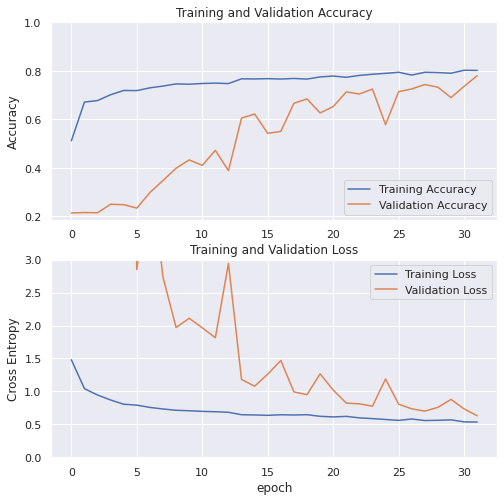

In [ ]:
# Function for training our model
epochs_ratio=(2,1) # training steps for (weights, architecture). x weight steps followed by y architecture steps
training_treshold=0.0001
epochs_weights=30 #following Guo, 2021. Used only on train_model2
epochs_architecture=30 #Not following Guo, 2021. Used only on train_model2

np.set_printoptions(precision=int(np.log10(1/training_treshold)), suppress=True)
#alternated training. Deprecated
def Train_model(net, trainX, trainY, valX,valY , batch_size, epochs, filepath, name): 
  fullHist={'loss':[], 'accuracy':[],'val_loss':[], 'val_accuracy':[]}
  print('Start training.. ')
  delta_scale=1
  epochs_cycle=epochs_ratio[0]+epochs_ratio[1]
  currSigmoids=[] #I'll save this only for printing    
  for epoch in range(epochs):
    if (epoch % epochs_cycle)>=epochs_ratio[0]: #Train the architecture #we are using a factor of 2 weights epochs then one architecture epoch. For some reason, it works faster.
    #if False: #use this to disable the architeture learning
      delta_scale=delta_scale*2
      if delta_scale>10000: delta_scale=10000 #This is the delta cap Guo (2021)
      currSigmoids=[] 
      for layer in net.layers:
        if layer.name.startswith("ss_"): #applying only to sigmoid gate layers
          layer.delta_scale=delta_scale #we save this for later use on the loss function
          curr_sigmoid=tf.math.sigmoid(layer.weights[0]*layer.delta_scale)
          layer.trainable = True
          currSigmoids.append(float(curr_sigmoid))
          #print(layer.name, curr_sigmoid, "Number of usable filters: ", int(tf.math.count_nonzero(tf.greater(curr_sigmoid,training_treshold))))
          #print(layer.name, curr_sigmoid) #shows the sigmoids with layer names
        else: 
          layer.trainable = False
      currSigmoids=np.array(currSigmoids)
      print("Architecture vector: ",currSigmoids)
      if np.logical_or((currSigmoids<0.0001), (1-currSigmoids)<0.0001).all():
        print("End of architecture learning. We should refine now.")
        # saving the model
        #net.save(os.path.join(root_path,name+'.h5'),overwrite=True)
        plotHistory(fullHist)
        return currSigmoids.round().astype(int).tolist()
      
      #training on validation dataset
      hist=net.fit(trainX, trainY,epochs=1, validation_data=(valX,valY))#,callbacks=[callback,checkpoint_callback])
    else:
      for layer in net.layers: #train the weights
        if layer.name.startswith("ss_"):
          layer.trainable = False
        else:
          layer.trainable = True
    
      hist=net.fit(trainX, trainY,epochs=1, validation_data=(valX,valY))#,callbacks=[callback,checkpoint_callback])
    fullHist = {key:np.hstack([fullHist[key],hist.history[key]]) for key in fullHist.keys()}
  
        
#Weight epochs followed by architecture epochs (Guo, 2021)
def Train_model2(net, trainX, trainY, valX,valY , batch_size, epochs, filepath, name): 
  print("Beginning full network weight training.")
  #we don't want it to train until completion, but I need to reach a reasonable accuracy for the network to be usable for architecture training
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001,patience=10)  

  #Let's freeze the sigmoids for weight training.
  for layer in net.layers: #train the weights
    if layer.name.startswith("ss_"):
      layer.trainable = False
    else:
      layer.trainable = True
  
  weight_history = net.fit(trainX, trainY,epochs=epochs_weights, validation_data=(valX,valY),callbacks=[earlystop])

  print("Beginning architecture learning.")
  for layer in net.layers: #now we only traing the sigmoid layers
    if layer.name.startswith("ss_"):
      layer.trainable = True
    else:
      layer.trainable = False
  delta_scale=1
  for epoch in range(epochs_architecture): #architecture training
    delta_scale=delta_scale*2 #the delta grows with epochs to force architecture to convergence
    if delta_scale>10000: delta_scale=10000 #This is the delta cap from Guo (2021)
    currSigmoids=[] 
    for layer in net.layers: #now we only traing the sigmoid layers
      if layer.name.startswith("ss_"):
        layer.delta_scale=delta_scale #we save this for later use on the loss function
        curr_sigmoid=tf.math.sigmoid(layer.weights[0]*layer.delta_scale)
        currSigmoids.append(float(curr_sigmoid))
        
        #print(layer.name, curr_sigmoid, "Number of usable filters: ", int(tf.math.count_nonzero(tf.greater(curr_sigmoid,training_treshold))))
      else:
        layer.trainable = False
    currSigmoids=np.array(currSigmoids)
    print("Architecture vector: ",currSigmoids)
    if np.logical_or((currSigmoids<0.0001), (1-currSigmoids)<0.0001).all():
      print("End of architecture learning. We should refine now.")
      # saving the model
      #net.save(os.path.join(root_path,name+'.h5'),overwrite=True)
      return currSigmoids.round().astype(int).tolist()

    history = net.fit(trainX, trainY,epochs=1, validation_data=(valX,valY))#,callbacks=[callback,checkpoint_callback])
    
  fullHist = {key:np.hstack([weight_history.history[key],history.history[key]]) for key in weight_history.history.keys()}
  plotHistory(fullHist)
epochs=100

start_arch = time.time()
#Custom training
loss = NAL_loss(net) #We pass the network because the loss function needs to access the sigmoid layers weights later.
#loss = tf.keras.losses.categorical_crossentropy
net.compile(loss = loss,optimizer=adam , metrics=['accuracy'])
architecture_vector=Train_model(net,trainX, trainY, valX,valY , batch_size, epochs, root_path, name)
end_arch = time.time()
#del net

# Prune the network

In [ ]:
del net #we don't need the old network anymore. Let's save some memory.
print(f"Architecture vector (result of sigmoids): {architecture_vector}")
#copy this vector if you want to reuse the trained architecture.

Architecture vector (result of sigmoids): [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


In [ ]:
#I added this to recover the vector because there was a bug on keras that kept me from saving the model.
#If you run into the same bug, save the architecture vector on the variable bellow, restart the runtime, run everything again and skip the architecture training.

#architecture_vector=[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
#architecture_vector=[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
endnet = NAL_unet(band_patches[1].shape, number_class,architecture_vector)
endnet.summary()

[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 8) 0                                            
__________________________________________________________________________________________________
conv1_x_32_3 (Conv2D)           (None, 256, 256, 32) 2336        input_5[0][0]                    
__________________________________________________________________________________________________
conv1_x_32_3_bn (BatchNormaliza (None, 256, 256, 32) 128         conv1_x_32_3[0][0]               
__________________________________________________________________________________________________
conv1_x_32_3_relu (ReLU)        (None, 256, 256, 32) 0           conv1_x_32_3_bn[0][0]            
_______________________________________________________

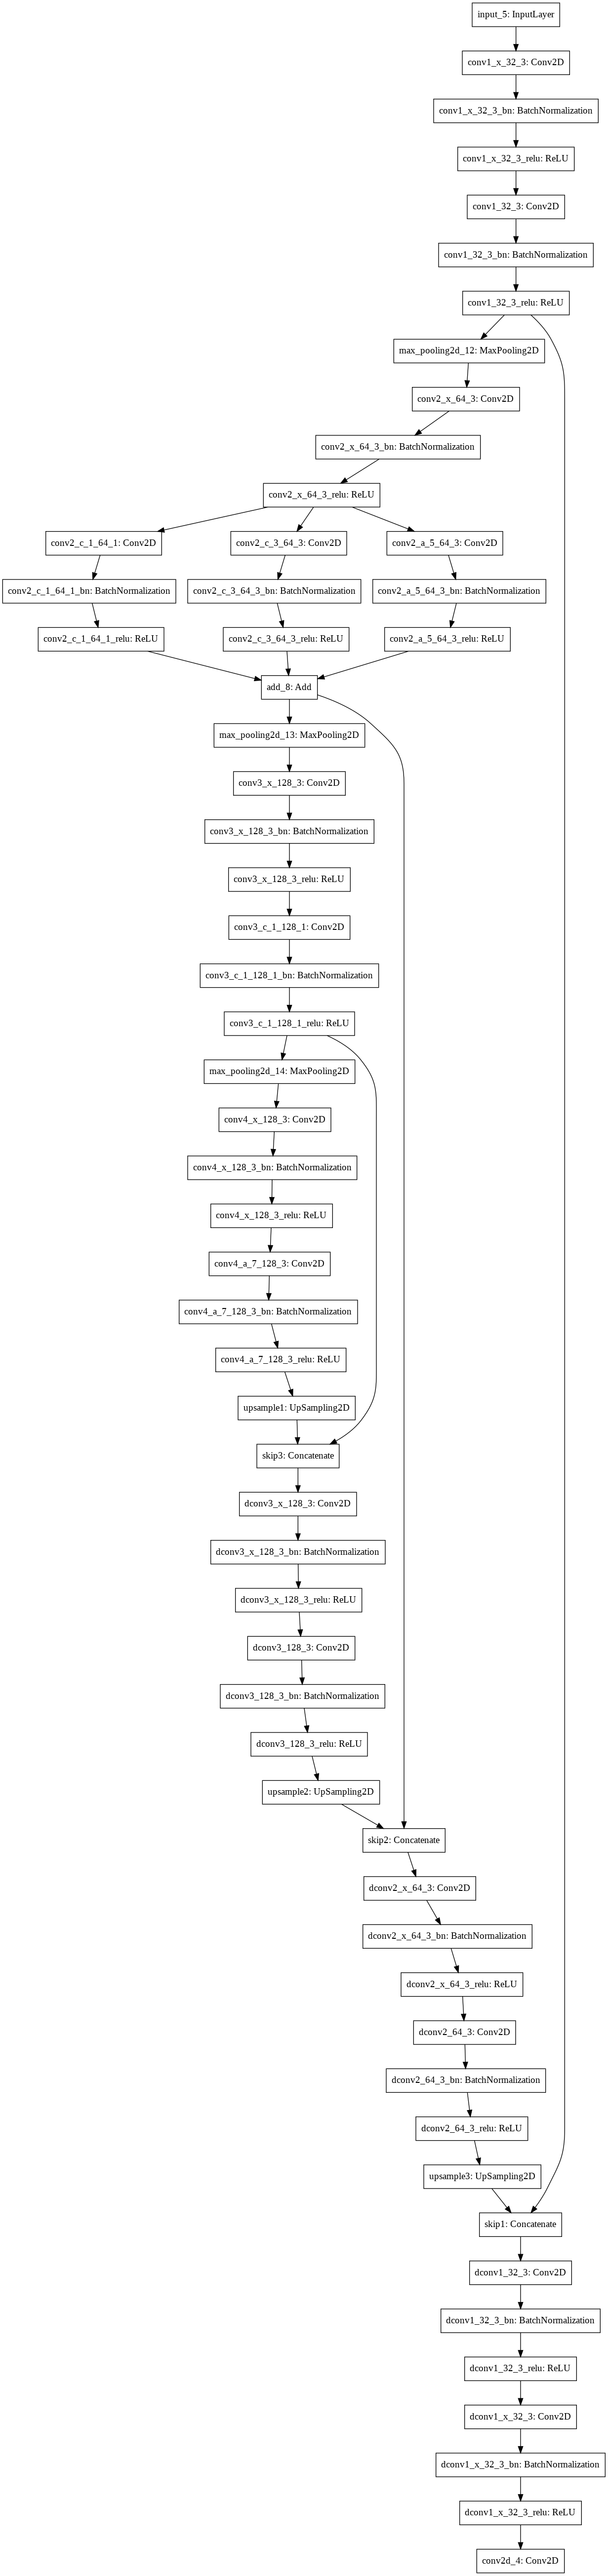

In [ ]:
plot_model(endnet, to_file='model_plot.png')

#NAL final network training

In [ ]:
name="nalunet"
basic_loss = tf.keras.losses.categorical_crossentropy
adam = Adam(learning_rate = learning_rate , beta_1=0.9)
endnet.compile(loss = basic_loss,optimizer=adam , metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001,patience=20)
if os.path.exists(os.path.join(root_path,name+'.h5')): 
  !rm "{os.path.join(root_path,name+'.h5')}"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(root_path,name+'.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
#Regular training
start_endnet = time.time()
history = endnet.fit(trainX, trainY,epochs=epochs, validation_data=(valX,valY),callbacks=[callback,checkpoint_callback])
end_endnet = time.time()

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.5149 - accuracy: 0.5026
Epoch 00001: val_accuracy improved from -inf to 0.21469, saving model to /content/nalunet.h5
13/13 [==============================] - 6s 443ms/step - loss: 1.5149 - accuracy: 0.5026 - val_loss: 12.4211 - val_accuracy: 0.2147
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 1.0691 - accuracy: 0.6798
Epoch 00002: val_accuracy improved from 0.21469 to 0.21581, saving model to /content/nalunet.h5
13/13 [==============================] - 5s 417ms/step - loss: 1.0691 - accuracy: 0.6798 - val_loss: 12.2801 - val_accuracy: 0.2158
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.7017
Epoch 00003: val_accuracy did not improve from 0.21581
13/13 [==============================] - 5s 405ms/step - loss: 0.9482 - accuracy: 0.7017 - val_loss: 7.3949 - val_accuracy: 0.2155
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.8771 

# **Test the model**

In [ ]:
imageId=8
band_image=band_images_pattern.format(imageId)
label_image=label_images_pattern.format(imageId)
bandArray = gdal_array.LoadFile(band_image)
bandArray = np.moveaxis(bandArray, 0, -1)
band_patches2=extract_patches(bandArray,patch_size,stride)
labelsArray = gdal_array.LoadFile(label_image) #this is a grayscale image
labelsArray = labelsArray.reshape(labelsArray.shape+(1,))
labelsArray = tf.keras.utils.to_categorical(labelsArray)
label_patches2=extract_patches(labelsArray,patch_size,stride)

In [ ]:
# Function for testing our model
def Test_model(model, patches_test):
  result = model.predict(patches_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

In [ ]:
print(f"Loading model from {os.path.join(root_path,name+'.h5')}")
model = load_model(os.path.join(root_path,name+'.h5'))
#model = load_model(os.path.join(root_path,baseline_name+'.h5'))
patches_pred = Test_model(model, band_patches2)
print('final label shape:', patches_pred.shape)

Loading model from /content/nalunet.h5
final label shape: (169, 256, 256)


# **Metrics**

<center>
<img align="center" width="700" height="300" src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/Metrics.png'>
</center>



In [ ]:
# Computing metrics
def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  return accuracy, f1score, recall, precision

In [ ]:
true_labels = np.argmax(label_patches2, axis=-1).flatten()
predicted_labels = patches_pred.flatten()
metrics = compute_metrics(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)
np.savetxt('cm.npy',cm)

print('Confusion  matrix \n', cm)
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix 
 [[  30631  207781   66405   72557   11257    6513     737     552]
 [  29620 2422349  117564  172786   47144   54828    1270    2730]
 [  18926  170154 1973696   72733   14697    2200     148     263]
 [  15631  488976   68677 1715291  278556    8130    1070    5732]
 [   8138  154600   11495  356578 1450202    2821   19870      89]
 [   1622   55510    4227    3642     817  128661      27       4]
 [   3635   10170    2032    6526   15038     200  568617       0]
 [    331   32628    5311   48982    3328     154       0  100725]]
Accuracy:  75.75376612194896
F1score:  [12.1319 75.8114 87.6765 68.1867 75.8309 64.651  94.9311 66.804 ]
Recall:  [ 7.7267 85.0457 87.6101 66.431  72.3728 66.1462 93.7974 52.6092]
Precision:  [28.2225 68.3861 87.7429 70.0377 79.636  63.2219 96.0925 91.4892]


Text(66.5, 0.5, 'True')

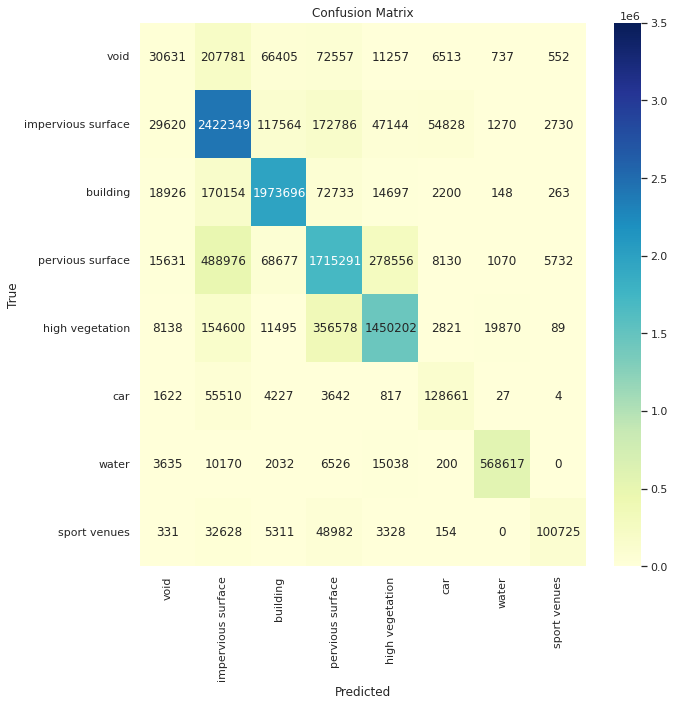

In [ ]:
plt.figure(figsize=(10,10))
#ticks_ = (y_gallery).astype(str)
ax = sns.heatmap(cm, annot=True, cmap ='YlGnBu', fmt="d",yticklabels=classes, xticklabels=classes,vmax=3.5*1e6) #, yticklabels = ticks_[::-1], xticklabels = ticks_
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# **Visualization**

Test sample No.  23


(-0.5, 255.5, 255.5, -0.5)

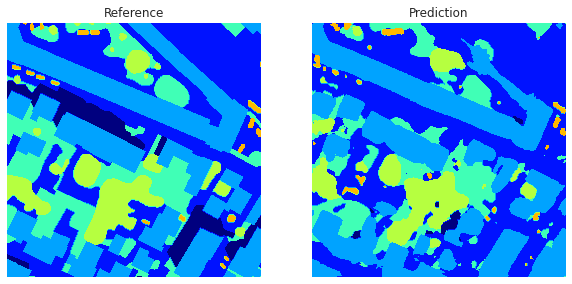

In [ ]:
fig = plt.figure(figsize = (10,10))
#n_sample = 14
n_sample = 23

cmap = plt.cm.get_cmap('jet', len(classes))   
colors=[cmap(i) for i in range(0,len(classes))]

print('Test sample No. ', n_sample)
plt.subplot(1,2,1)
plt.imshow(np.argmax(label_patches2[n_sample,:,:], axis=-1), cmap = cmap, vmin = 0, vmax = len(classes)-1)
plt.title('Reference')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(patches_pred[n_sample,:,:], cmap = cmap, vmin = 0, vmax = len(classes)-1)
plt.title('Prediction')
plt.axis('off')

# Baseline model


In [ ]:
def baseline_model(input_shape, n_classes):
  input_img = Input(input_shape)
  n_filters = [32, 64, 128, 128]
  max_filters=64
  ## ENCODER
  x= conv(input_img,n_filters[0],3,'conv1_x')
  conv1= conv(x,n_filters[0],3,'conv1')
  x = MaxPool2D((2 , 2))(conv1)

  x= conv(x,n_filters[1],3,'conv2_x')
  conv2= conv(x,n_filters[1],3,'conv2')
  x = MaxPool2D((2 , 2))(conv2)

  x= conv(x,n_filters[2],3,'conv3_x')
  conv3= conv(x,n_filters[2],3,'conv3')
  x = MaxPool2D((2 , 2))(conv3)

  ## MIDDLE
  x= conv(x,n_filters[3],3,'conv4_x')
  conv4= conv(x,n_filters[3],3,'conv4')

  ## DECODER
  x = UpSampling2D(size = (2,2), name="upsample1")(conv4)
  x = Concatenate(name ='skip3')([x,conv3])
  x= conv(x,n_filters[2],3,'dconv3_x')
  x= conv(x,n_filters[2],3,'dconv3')

  x = UpSampling2D(size = (2,2), name="upsample2")(x)
  x = Concatenate(name ='skip2')([x,conv2])
  x= conv(x,n_filters[1],3,'dconv2_x')
  x= conv(x,n_filters[1],3,'dconv2')
  
  x = UpSampling2D(size = (2,2), name="upsample3")(x)
  x = Concatenate(name ='skip1')([x,conv1])
  x= conv(x,n_filters[0],3,'dconv1_x')
  x= conv(x,n_filters[0],3,'dconv1')
  

  output = Conv2D(n_classes,(1,1), activation = 'softmax')(x)
  
  return Model(input_img , output) 

# Baseline training

In [ ]:
baseline_name="unet"
basenet = baseline_model(band_patches[1].shape, number_class)
basic_loss = tf.keras.losses.categorical_crossentropy
basenet.compile(loss = basic_loss,optimizer=adam , metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001,patience=15)
modelFileName=os.path.join(root_path,baseline_name+'.h5')
if os.path.exists(modelFileName): 
  os.unlink(modelFileName)
checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(modelFileName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
basenet.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 8) 0                                            
__________________________________________________________________________________________________
conv1_x_32_3 (Conv2D)           (None, 256, 256, 32) 2336        input_7[0][0]                    
__________________________________________________________________________________________________
conv1_x_32_3_bn (BatchNormaliza (None, 256, 256, 32) 128         conv1_x_32_3[0][0]               
__________________________________________________________________________________________________
conv1_x_32_3_relu (ReLU)        (None, 256, 256, 32) 0           conv1_x_32_3_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
#Regular training
start_base = time.time()
history = basenet.fit(trainX, trainY,epochs=epochs, validation_data=(valX,valY),callbacks=[callback]) #
end_base = time.time()

Epoch 1/100
13/13 [==============================] - 6s 436ms/step - loss: 1.3892 - accuracy: 0.5510 - val_loss: 12.6396 - val_accuracy: 0.2158
Epoch 2/100
13/13 [==============================] - 5s 362ms/step - loss: 1.0397 - accuracy: 0.6494 - val_loss: 12.6260 - val_accuracy: 0.2167
Epoch 3/100
13/13 [==============================] - 5s 365ms/step - loss: 0.9562 - accuracy: 0.6700 - val_loss: 12.6294 - val_accuracy: 0.2159
Epoch 4/100
13/13 [==============================] - 5s 365ms/step - loss: 0.8978 - accuracy: 0.6868 - val_loss: 11.3803 - val_accuracy: 0.2926
Epoch 5/100
13/13 [==============================] - 5s 366ms/step - loss: 0.8603 - accuracy: 0.6904 - val_loss: 12.6351 - val_accuracy: 0.2140
Epoch 6/100
13/13 [==============================] - 5s 364ms/step - loss: 0.8296 - accuracy: 0.7071 - val_loss: 12.3571 - val_accuracy: 0.2062
Epoch 7/100
13/13 [==============================] - 5s 366ms/step - loss: 0.8000 - accuracy: 0.7100 - val_loss: 12.2379 - val_accuracy:

# Baseline visualization

In [ ]:
predict=Test_model(basenet,band_patches2)


In [ ]:
predicted_labels2 = predict.flatten()
metrics2 = compute_metrics(true_labels, predicted_labels2)
cm2 = confusion_matrix(true_labels, predicted_labels2)
np.savetxt('cm2.npy',cm2)

print('Confusion  matrix \n', cm2)
print('Accuracy: ', metrics2[0])
print('F1score: ', metrics2[1])
print('Recall: ', metrics2[2])
print('Precision: ', metrics2[3])

Confusion  matrix 
 [[  45400  188505   36795   93827   20910    8940    2056       0]
 [  29017 2183956  107170  392868   92754   40724     859     943]
 [  26433  121291 1919985  158389   22645    2727     532     815]
 [   6755  160001   39332 2123690  245770    4866     542    1107]
 [   1166   42712    6876  459430 1484362    1564    7674       9]
 [   1837   64807    2960    7930    1450  115525       1       0]
 [   2389    8717    3444    3823   19247      29  568569       0]
 [    261   29725    8491   94260    8476      84     459   49703]]
Accuracy:  76.66584443763868
F1score:  [17.8147 77.3355 87.7132 71.7914 76.1327 62.6204 95.8066 40.7342]
Recall:  [11.4521 76.676  85.226  82.2478 74.0776 59.3928 93.7895 25.9601]
Precision:  [40.0855 78.0064 90.35   63.6938 78.3051 66.219  97.9123 94.5337]


In [ ]:
print(classes)
print(metrics[1])
print(metrics2[1])

['void', 'impervious surface', 'building', 'pervious surface', 'high vegetation', 'car', 'water', 'sport venues']
[12.1319 75.8114 87.6765 68.1867 75.8309 64.651  94.9311 66.804 ]
[17.8147 77.3355 87.7132 71.7914 76.1327 62.6204 95.8066 40.7342]


Text(66.5, 0.5, 'True')

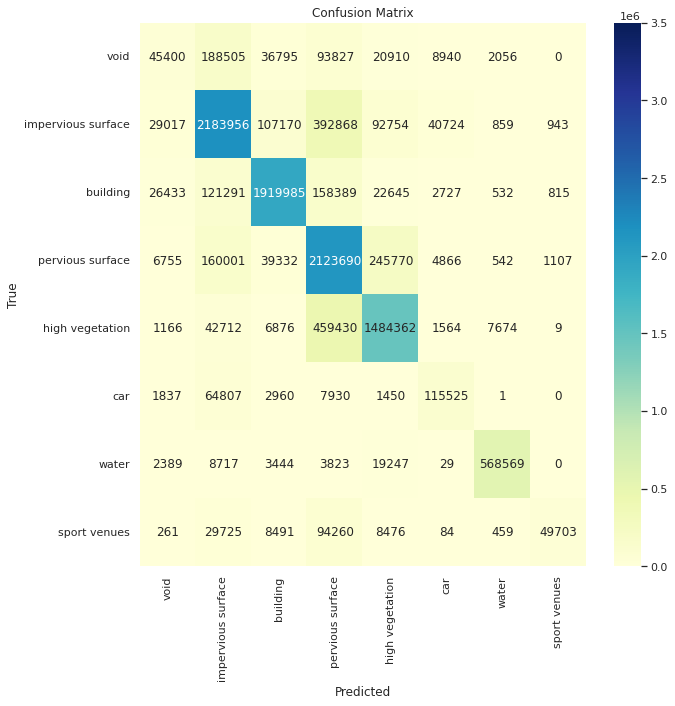

In [ ]:
plt.figure(figsize=(10,10))
#ticks_ = (y_gallery).astype(str)
ax = sns.heatmap(cm2, annot=True, cmap ='YlGnBu', fmt="d",yticklabels=classes, xticklabels=classes,vmax=3.5*1e6) #, yticklabels = ticks_[::-1], xticklabels = ticks_
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test sample No.  23


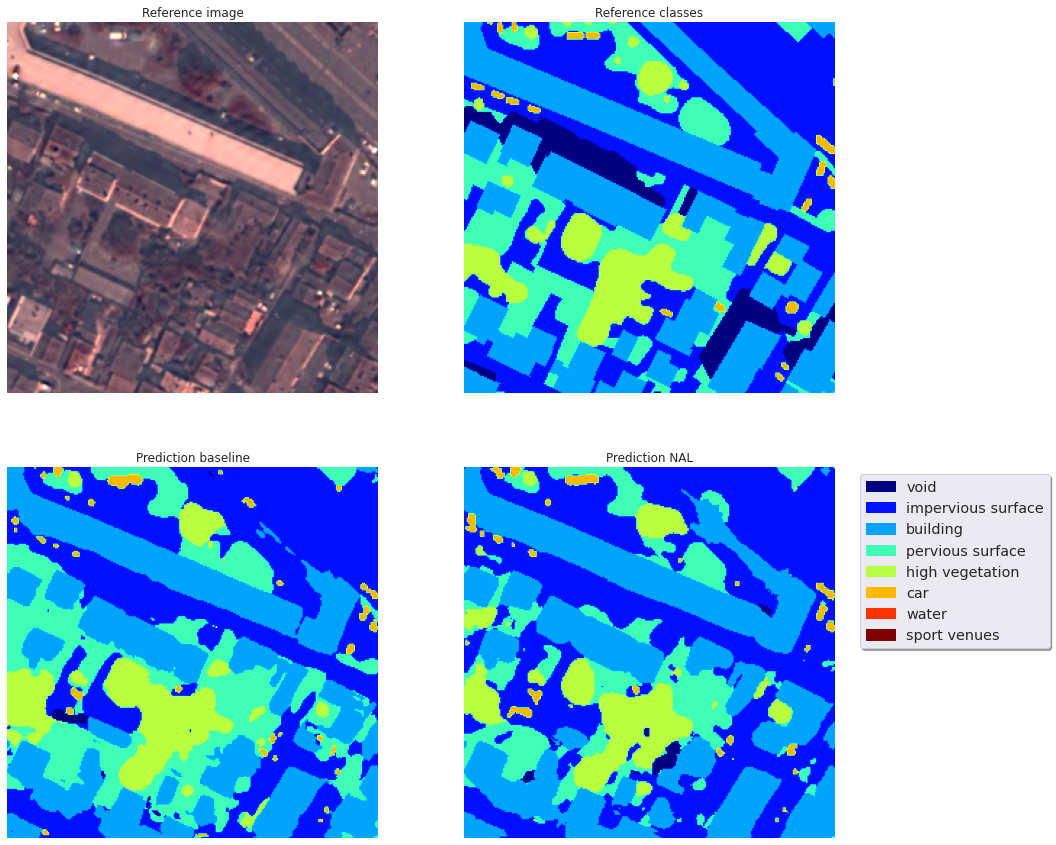

In [ ]:

fig = plt.figure(figsize = (15,15))
#n_sample = 14
n_sample = 23


cmap = plt.cm.get_cmap('jet', len(classes))   
colors=[cmap(i) for i in range(0,len(classes))]


print('Test sample No. ', n_sample)
plt.subplot(2,2,1)
plt.imshow(np.flip(band_patches2[n_sample,:,:,:3],2)/scale*5)
plt.title('Reference image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.argmax(label_patches2, axis=-1)[n_sample,:,:], cmap = 'jet',vmin = 0, vmax = len(classes)-1)
plt.title('Reference classes')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(predict[n_sample], cmap = 'jet',vmin = 0, vmax = len(classes)-1)
plt.title('Prediction baseline')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(patches_pred[n_sample], cmap = 'jet',vmin = 0, vmax = len(classes)-1)
plt.title('Prediction NAL')
plt.axis('off')

handles = [matplotlib.patches.Patch(color=colors[i], label=classes[i]) for i in range(0,len(classes))]
plt.legend(handles=handles, shadow=True, ncol=1, fontsize ='large',bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [ ]:
print(patches_pred[n_sample].shape)
print(predict[n_sample].shape)

(256, 256)
(256, 256)


In [ ]:
print("Elapsed time")
print(f"Training architecture: {int(end_arch-start_arch)}")
print(f"Training final network: {int(end_endnet-start_endnet)}")
print(f"Training Baseline: {int(end_base-start_base)}")

Elapsed time
Training architecture: 232
Training final network: 413
Training Baseline: 426
